# Single Response Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import fsolve

In [2]:
# experimental data - measurements
tspan = np.array([0, 0.1, 0.2, 0.4, 0.8, 1])
Ca_data = np.array([2.0081,  1.5512,  1.1903,  0.7160,  0.2562,  0.1495])
Ca0 = Ca_data[0]

# 1st example with curve_fit

The estimated value of rate constant is 2.5889431654658397


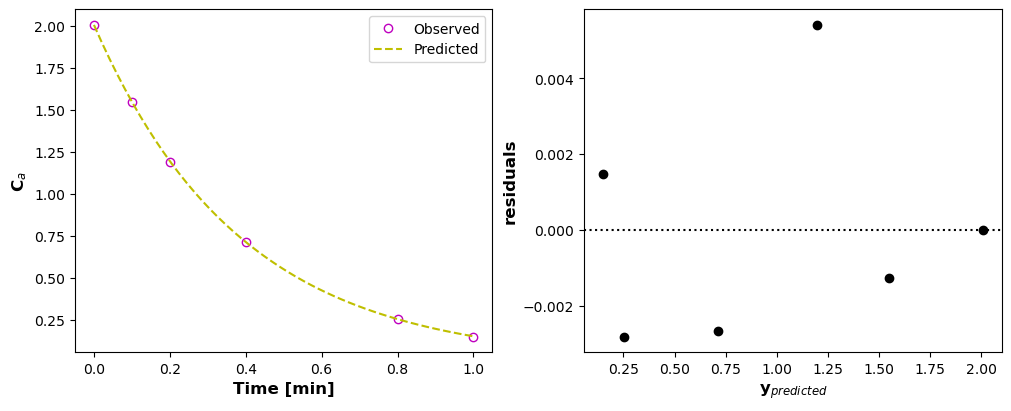

In [3]:
def y_calc(t, p):

    sol_ode = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), 
                        [Ca0], 
                        t_eval = t,
                        args = (p, ))

    return sol_ode.y[0]

# print(y_calc(tspan, 1))

# curve_fit(y_calc, t = tspan, y = Ca_data, p = p0)
params, kcov = curve_fit(y_calc, tspan, Ca_data, p0 = 1.3)

# unpack params
k = params

# find a sequence of inputs between the smallest and largest known inputs
tfit = np.linspace(min(tspan), max(tspan))

# calculate the output for the range
fit_y = y_calc(tfit, k)

fig, ax = plt.subplots(ncols = 2, figsize = (10, 4), constrained_layout = True)
ax[0].plot(tspan, Ca_data, 'mo', mfc = 'None', label='Observed')
ax[0].plot(tfit, fit_y, 'y--', label='Predicted')
ax[0].legend(loc='best')
ax[0].set_xlabel('Time [min]', fontsize=12, fontweight='bold')
ax[0].set_ylabel('C$_a$', fontsize=12, fontweight='bold')

ax[1].plot(y_calc(tspan, k), y_calc(tspan, k) - Ca_data, 'ko')
ax[1].set_xlabel('y$_{predicted}$', fontsize=12, fontweight='bold')
ax[1].set_ylabel('residuals', fontsize=12, fontweight='bold')
ax[1].axhline(y = 0, color = 'k', linestyle = ":")

print('The estimated value of rate constant is', k[0])

# 1st example with SLSQP

The estimated value of rate constant is 2.588937955931732


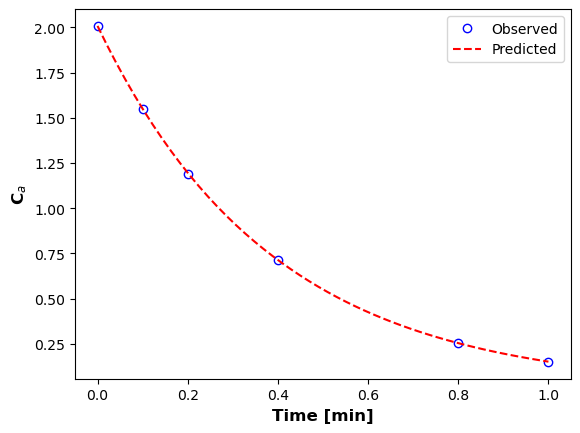

In [4]:
def y_calc(t, p):
    
    ode_sol = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), 
                        [Ca0], 
                        args=(p,), 
                        t_eval = t)
    
    return ode_sol.y[0]

# where p is the vector of the unknown parameters, t is the independent variable, and y represents the measurements
min_fun = lambda p, t, y, f: np.linalg.norm(y - f(t, p))

# args = (experimental values)
res_min = minimize(min_fun, 
               [1.3], # initial value of k
               args=(tspan, Ca_data, y_calc), 
               method='SLSQP',
               bounds=[(0.0, np.inf)])

k = res_min.x
tfit = np.linspace(min(tspan), max(tspan))

# y_pred for the best parameter value
y_pred = y_calc(tfit, k)

plt.plot(tspan, Ca_data, "bo", mfc = 'None', label = 'Observed')
plt.plot(tfit, y_pred, "r--", label = 'Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

print('The estimated value of rate constant is', k[0])

# 1st example with least_squares

`gtol` termination condition is satisfied.
Function evaluations 16, initial cost 9.5472e-04, final cost 2.4000e-05, first-order optimality 8.58e-09.
The estimated value of rate constant is 2.588943148803517


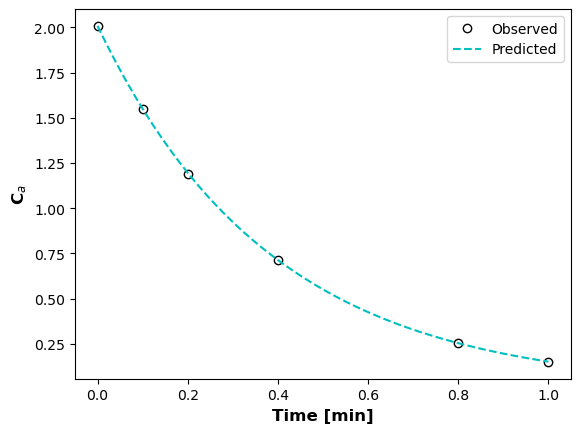

In [5]:
def y_calc(t, p):
    
    ode_sol = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), [Ca0], 
                        t_eval = t,
                        args = (p,))
    
    return ode_sol.y[0]

min_fun = lambda p, t, y, f: np.linalg.norm(y - f(t, p))

# least_squares(min_fun, p = p0, bnds, args = (t = tspan, y = Ca_data)) - arguments of lambda follow the same order p, t, y
res_lsq = least_squares(min_fun, 
                        [2.5],
                        bounds = (0.0, np.inf),
                        args = (tspan, Ca_data, y_calc),
                        verbose = 1)

k = res_lsq.x
tfit = np.linspace(min(tspan), max(tspan))

# y_pred for the best parameter value
y_pred = y_calc(tfit, k)

plt.plot(tspan, Ca_data, "ko", mfc = 'None', label = 'Observed')
plt.plot(tfit, y_pred, "c--", label = 'Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

print('The estimated value of rate constant is', k[0])

# 1st example with lmfit

[[Model]]
    Model(y_calc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 6
    # variables        = 1
    chi-square         = 4.8001e-05
    reduced chi-square = 9.6001e-06
    Akaike info crit   = -68.4163437
    Bayesian info crit = -68.6245843
    R-squared          = 0.99998229
[[Variables]]
    p:  2.58894319 +/- 0.00651337 (0.25%) (init = 1)


Text(0, 0.5, 'C$_a$')

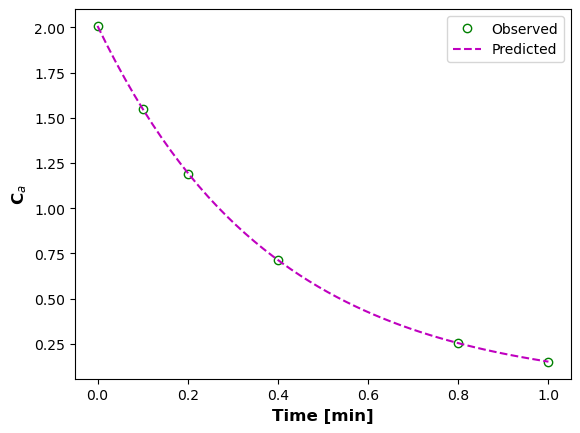

In [6]:
def y_calc(t, p):

    sol_ode = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), 
                        [Ca0], 
                        t_eval = t,
                        args = (p, ))

    return sol_ode.y[0]

mod_original = Model(y_calc)
params_original = mod_original.make_params(p = 1.0)

result = mod_original.fit(Ca_data, params_original, t=tspan)

print(result.fit_report())

tfit = np.linspace(min(tspan), max(tspan))
best_values = np.array(list(result.best_values.values()))
best_fit = result.best_fit

plt.plot(tspan, Ca_data, "go", mfc = 'None', label = 'Observed')
plt.plot(tfit, y_calc(tfit, best_values), "m--", label = 'Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

# 2nd example with curve_fit (fake data)

b=0.020403969367857256, y0 = 1.0094309710043414


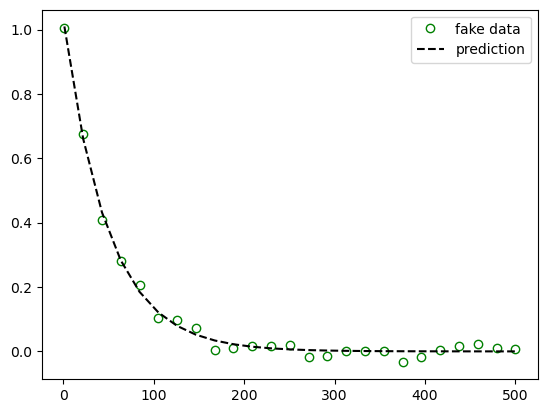

In [7]:
# when we have more than 1 parameter to optimize use *
def curve(t, *p):
    
    b, y0 = p

    sol = solve_ivp(lambda t, y, b: -b*y,
                   (xmin, xmax), 
                   [y0], 
                   t_eval= t,
                   args = (b,)) # we only care about the argument of the ode
    
    return sol.y[0]

xmin, xmax = 1, 500
n_points = 25 # here we can see that a significant lower number of points are needed in comparison to least_squares method

xdata = np.linspace(xmin, xmax, n_points)
ydata = np.exp(-0.02*xdata)+0.02*np.random.randn(*xdata.shape)

y0 = 5
b= 0.005
p0 = [b, y0]

popt, pcov = curve_fit(curve, xdata, ydata, p0=p0)
b, y0 = popt

print(f"b={b}, y0 = {y0}")

plt.plot(xdata, ydata, 'go', mfc = 'none', label = 'fake data')
plt.plot(xdata, curve(xdata, b, y0), 'k--', label = 'prediction')
plt.legend()

# 2nd example with least_squares (fake data)

b=0.01952705493351394, y0 = 0.9749625903499657


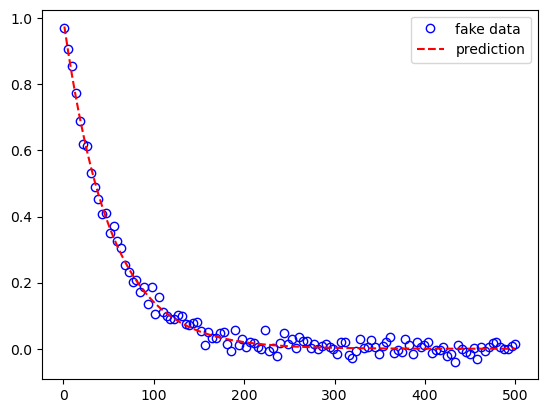

In [8]:
# when we have more than 1 parameter to optimize use * for unpacking
def curve(t, *p):
    
    b, y0 = p

    sol = solve_ivp(lambda t, y, b: -b*y,
                   (xmin, xmax), 
                   [y0], 
                   t_eval= t,
                   args = (b,)) # argument existed in ode
    
    return sol.y[0]


xmin, xmax = 1, 500
n_points = 120 # note that more points are needed in order to fit the curve in comparison to curve_fit

xdata = np.linspace(xmin, xmax, n_points)
ydata = np.exp(-0.02*xdata)+0.02*np.random.randn(*xdata.shape)

y0 = 5
b= 0.005
p0 = [b, y0]

fun = lambda p, t, y, f: np.linalg.norm(y - f(t, *p))

res_lsq = least_squares(fun,
                        p0,
                        bounds = ([0, 0], np.inf),
                        args = (xdata, ydata, curve)
                       )

b, y0 = res_lsq.x

print(f"b={b}, y0 = {y0}")

plt.plot(xdata, ydata, 'bo', mfc = 'none', label = 'fake data')
plt.plot(xdata, curve(xdata, b, y0), 'r--', label = 'prediction')
plt.legend()